# Tutorial on fitting with `ticktack` and `emcee`

Let's go through an example of how you would fit the original Miyake event time series from 774 AD ([Miyake et al, 2012](https://www.nature.com/articles/nature11123)) using tools from `ticktack`. First we import everything.

In [10]:
import numpy as np
import ticktack
from ticktack import fitting
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from chainconsumer import ChainConsumer


Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler15'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model("Guttler15", production_rate_units = "atoms/cm^2/s")

Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm, cbm_model="Guttler15")
sf.load_data("miyake12.csv")
sf.compile_production_model(model="simple_sinusoid")

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this. Note that in input cell 3, we set the production rate model to be `SingleFitter.simple_sinusoid` using the keyword argument `model="simple_sinusoid"`. The parameters of this model are: arrival time in CE, duration in years, solar cycle phase in years, and total radiocarbon delivered in production rate times years. The complete documentation on `SingleFitter.compile_production_model` can be found [here](https://sharmallama.github.io/ticktack/sf_api/#fitting.SingleFitter.compile_production_model).

In [4]:
%%time
default_params = np.array([775., np.log10(1./12), np.pi/2., np.log10(81./12)]) # start date, duration, phase, area
sampler = sf.MarkovChainSampler(default_params, 
                                likelihood = sf.log_joint_likelihood, 
                                burnin = 500, 
                                production = 2000, 
                                args = (np.array([770., np.log10(1/52.), 0, -2]), # lower bound
                                np.array([780., np.log10(5.), 11, 1.5]))         # upper bound 
                               )
samples = sampler.copy()
samples[:,1] = 10**samples[:,1] # duration not log duration
samples[:,-1] = 10**samples[:,-1] # area not log area

Running burn-in...


100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


Running production...


100%|██████████| 2000/2000 [08:01<00:00,  4.15it/s]

CPU times: user 10min 2s, sys: 4.89 s, total: 10min 7s
Wall time: 10min 10s


In the input cell above, we specified the initial values of the parameters for the MCMC sampler and their bounding values. When fitting a different event, the initial and the bounding values of start date should be adjusted to be consistent with the time sampling of that event. For our sinusoid models, we also fix the solar cycle duration at 11-years. Therefore, the bounding values of solar cycle phase is 0 and 11.

In [13]:
def chain_summary(sf, chain, walkers, figsize=(10, 10), labels=None, plot_dist=False,
                    label_font_size=8, tick_font_size=8, mle=False,usetex=False):
    """
    Runs convergence tests and plots posteriors from a MCMC chain.
    Parameters
    ----------
    chain : ndarray
        A MCMC chain
    walkers : int
        The total number of walkers of the chain
    figsize : tuple, optional
        Output figure size
    labels : list[str], optional
        A list of parameter names
    plot_dist : bool, optional
        If True, plot the marginal distributions of parameters. Else, plot both the marginal distribution
            and the posterior surface
    """
    c = ChainConsumer().add_chain(chain, walkers=walkers, parameters=labels)

    c.configure(spacing=0.0, usetex=usetex, label_font_size=label_font_size, tick_font_size=tick_font_size,
                diagonal_tick_labels=False,summary=False)
    fig = c.plotter.plot(figsize=figsize)
        
    return fig


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

100%|██████████| 30/30 [00:00<00:00, 101.62it/s]


Text(0, 0.5, 'Production rate (atoms cm$^2$s$^{-1}$)')

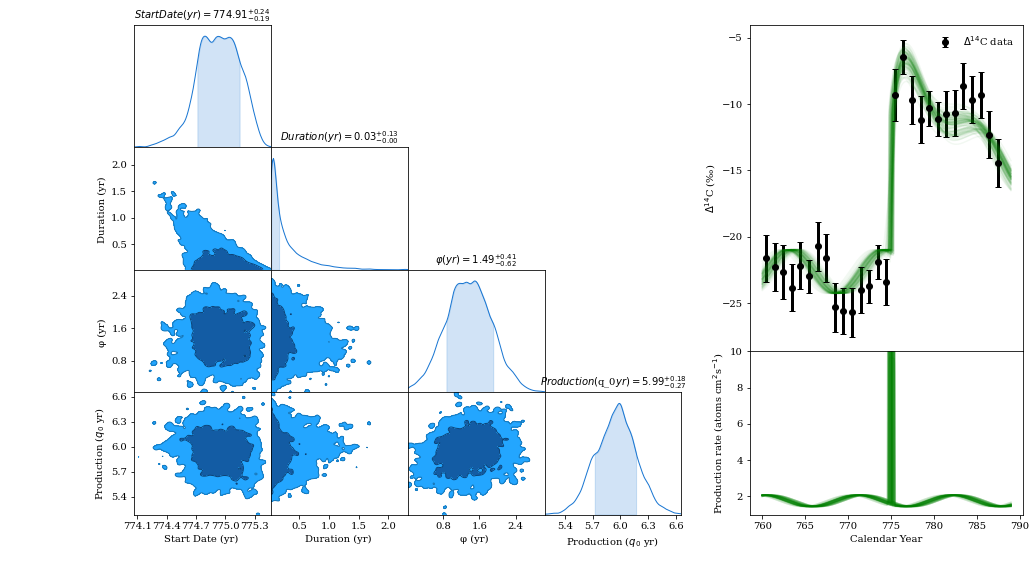

In [15]:
labels = ["Start Date (yr)", "Duration (yr)", "φ (yr)", "Production ($q_0$ yr)"]
fig = chain_summary(sf, samples, 8, labels=labels, figsize=(19.0,8.0), label_font_size=10, tick_font_size=10,)
# fig = sf.chain_summary(samples, 8, labels=labels, label_font_size=10, tick_font_size=10,usetex=False)
fig.subplots_adjust(right=0.5)

gs = mpl.gridspec.GridSpec(1,2, width_ratios=[1, 1])

subfig = fig.add_subfigure(gs[0, 1])

(ax1, ax2) = subfig.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [2, 1]})
# fig.subplots_adjust(hspace=0.05)
plt.rcParams.update({"text.usetex": False})
idx = np.random.randint(len(sampler), size=100)
for param in tqdm(sampler[idx]):
    ax1.plot(sf.time_data_fine, sf.dc14_fine(params=param), alpha=0.05, color="g")

for param in tqdm(sampler[idx][:30]):
    ax2.plot(sf.time_data_fine, sf.production(sf.time_data_fine, *param), alpha=0.2, color="g")

ax1.errorbar(sf.time_data + sf.time_offset, sf.d14c_data, yerr=sf.d14c_data_error, 
             fmt="ok", capsize=3, markersize=6, elinewidth=3, label="$\Delta^{14}$C data")
ax1.legend(frameon=False);
ax2.set_ylim(1, 10);
ax1.set_ylabel("$\Delta^{14}$C (‰)")
ax2.set_xlabel("Calendar Year");
ax2.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)")

# plt.savefig('joss_figure.png',bbox_inches='tight',dpi=300)